# Analyze r/loseit Challenge Data

Now we can read in the already cleaned file. If you don't have the cleaned data, you will need to run [Find and Clean Loseit Data](01_clean_loseit_challenge_data.ipynb) and [Inspect Loseit Data](02_inspect_loseit_challenge_data.ipynb).

In [1]:
import datetime as dt
import itertools
import os
import re
import warnings
from collections import Counter

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from IPython.display import HTML, display
from matplotlib_venn import venn3, venn3_circles
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import STOPWORDS, ImageColorGenerator, WordCloud

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
color = sns.color_palette()
%matplotlib inline

nlp = spacy.load("en")
# nlp = spacy.load('en_core_web_md')

We begin by loading in the dataset and look at the counts.

In [2]:
big_df = pd.read_csv(
    "../data/processed_data/outlier_fized_loseit_challenge_data.csv", index_col=0
)
big_df["NSV Text"] = big_df["NSV Text"].astype(str).replace("nan", "")
age_df = pd.read_csv(
    "../data/processed_data/age_outlier_loseit_challenge_data.csv", index_col=0
)
loss_df = pd.read_csv(
    "../data/processed_data/weight_loss_outlier_loseit_challenge_data.csv", index_col=0
)

In [3]:
# here we are going to set some of the plotting parameters that we will use for all of the plots.
sns.set(style="ticks", context="talk")
sns.set_palette("colorblind")
# for printing bold
start = "\033[1m"
end = "\033[0;0m"

## Participant Stats

### Username

From participating in a few different challenges, I know there are many people who have done multiple challenges. I want to begin by looking at how many have done more than one challenge, and who has participated in the most challenges.

In [4]:
duplicate_df = big_df[big_df.duplicated(subset=["Username"])]
no_duplicate_df = big_df[~big_df.duplicated(subset=["Username"], keep=False)]
print(
    f"multiple challenges: {len(duplicate_df.Username.value_counts())} and single challenge: {len(no_duplicate_df.Username.value_counts())}"
)

print(
    f"\nSo we can see that there have been {len(duplicate_df.Username.value_counts())} people who have participated in more than one challenge (and using the same username) and {len(no_duplicate_df.Username.value_counts())} people who have only participated in a single challenge so far -- again this doesn't account for people who sign-up using multiple accounts."
)

multiple challenges: 1539 and single challenge: 4568

So we can see that there have been 1539 people who have participated in more than one challenge (and using the same username) and 4568 people who have only participated in a single challenge so far -- again this doesn't account for people who sign-up using multiple accounts.


In [5]:
# because the first occurance was not counted
print((duplicate_df.Username.value_counts() + 1).head(15).to_string())

axecutable             10
lovellama              10
bugs_bunny01           10
kej9311                 9
blackanemones           9
mrbad-example           9
soylouisebrooks         9
getmotivatednow         8
blackesthearted         8
unreuly                 8
shd244                  8
kovvu_kariginchu        8
thosethighstho          8
radiant_indignation     8
kmrbriscoe              8


In [6]:
num_challenges = big_df.Username.value_counts()

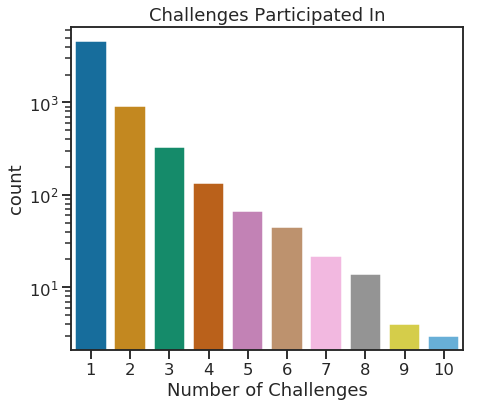

In [7]:
f, ax = plt.subplots(figsize=(7, 6))
sns.countplot(num_challenges)
ax.set_yticks([])
ax.set_yscale("log")
ax.set_xlabel("Number of Challenges")
ax.set_title("Challenges Participated In")
f.tight_layout()
f.savefig("../figures/challenges_partipicated_in.png", dpi=400)

Comment about the number of challenges that people participate in.

### Gender

Let's start by looking at the gender distribution of r/loseit participants.

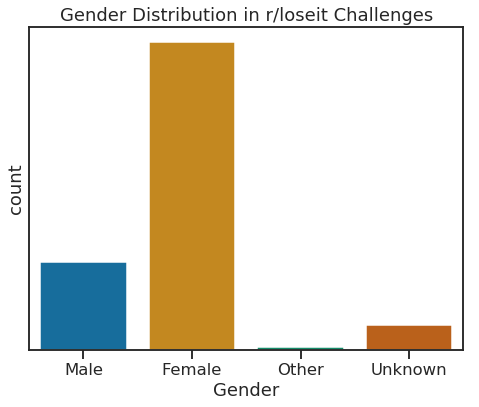

In [8]:
f, ax = plt.subplots(figsize=(7, 6))
sns.countplot(x="Gender", data=big_df)
ax.set_yticks([])
ax.set_title("Gender Distribution in r/loseit Challenges")
f.tight_layout()
f.savefig("../figures/gender_bar_chart.png", dpi=400)

In [9]:
print(
    f' Males: {(100 * len(big_df[big_df.Gender == "Male"])/len(big_df)):.2f}%,'
    f' Females: {(100 * len(big_df[big_df.Gender == "Female"])/len(big_df)):.2f}%,'
    f' Other: {(100 * len(big_df[big_df.Gender == "Other"])/len(big_df)):.2f}%,'
    f' Unknown: {(100 * len(big_df[big_df.Gender == "Unknown"])/len(big_df)):.2f}%'
)

 Males: 20.84%, Females: 72.39%, Other: 0.76%, Unknown: 6.02%


Looking that this plot it is obvious that loseit challenges have a very large gender imbalance. Around 71% of the participants in the challenges are women, 20% are male, 7% are unknown, and just under 1% of participants identify as other. Because there is such a large imbalance, for most of my analysis I will try and look at how the numbers vary between gender -- if they do at all.

### Age

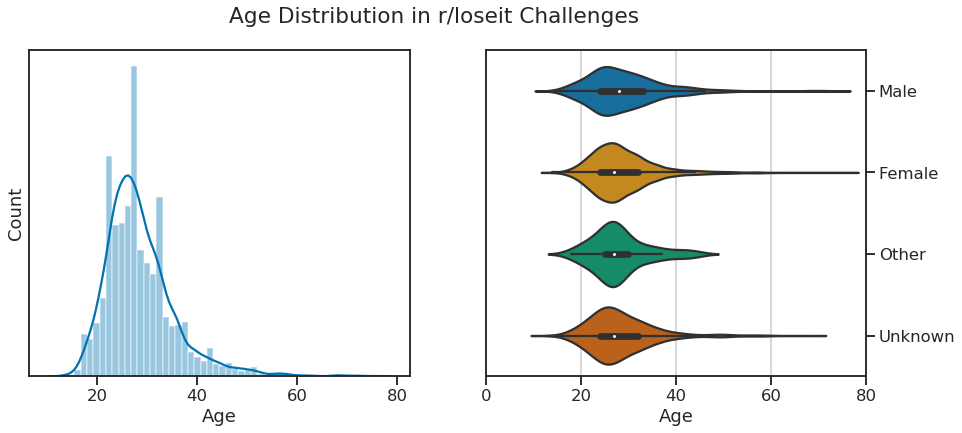

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.distplot(age_df["Age"], ax=ax1)
ax1.set_yticks([])
ax1.set_ylabel("Count")

sns.violinplot(x="Age", y="Gender", data=age_df, ax=ax2)
ax2.xaxis.grid(True)
ax2.set(ylabel="")
ax2.set_xlim([0, 80])
# ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

# ax2.set_title('Age Distribution in r/loseit Challenges')
f.suptitle("Age Distribution in r/loseit Challenges")

f.savefig("../figures/violin_gender_age.png", dpi=400)

In [11]:
print(
    f'most common: {Counter(age_df["Age"]).most_common(1)}, average: {age_df["Age"].mean():.1f}, youngest: {age_df["Age"].min()}, oldest: {age_df["Age"].max()}'
)

most common: [(26.0, 706)], average: 28.7, youngest: 13.0, oldest: 76.0


Looking at the age distributions, we find that there is a large peak at the most common age 26. The oldest participant is 76 and the youngest has been 13. Looking the distributions separated by gender, we see that there us not a huge difference between them.

One thing of note, is that there are many people who have done multiple challenges. These results might change slightly if we were only look at the distributions for unique usernames.

In [12]:
no_dup_age_df = age_df[~age_df.duplicated(subset=["Username"])]

In [13]:
print(
    f'most common: {Counter(no_dup_age_df["Age"]).most_common(1)}, '
    f'average: {no_dup_age_df["Age"].mean():.1f}, youngest: {no_dup_age_df["Age"].min()}, '
    f'oldest: {no_dup_age_df["Age"].max()}'
)

most common: [(26.0, 475)], average: 28.4, youngest: 13.0, oldest: 76.0


So we find that even with removing duplicate usernames, the most common age of participants is still 26.

### Height

The next piece of information that I want to look at is the height distribution.

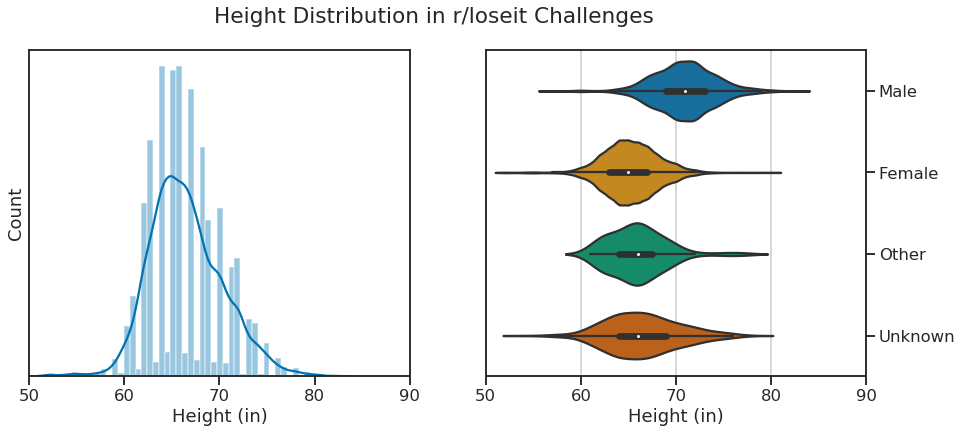

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.distplot(big_df["Height"], ax=ax1)
ax1.set_yticks([])
ax1.set_ylabel("Count")
ax1.set_xlim([50, 90])
ax1.set_xlabel("Height (in)")

sns.violinplot(x="Height", y="Gender", data=big_df, ax=ax2)
ax2.xaxis.grid(True)
ax2.set(ylabel="")
ax2.set_xlim([50, 90])
ax2.set_xlabel("Height (in)")
ax2.yaxis.tick_right()

# ax2.set_title('Age Distribution in r/loseit Challenges')
f.suptitle("Height Distribution in r/loseit Challenges")

f.savefig("../figures/violin_gender_height.png", dpi=400)

In [15]:
print(
    f'average: {big_df["Height"].mean():.1f} in, shortest: {big_df["Height"].min()} in, '
    f'tallest: {big_df["Height"].max()} in'
)

average: 66.5 in, shortest: 52.0 in, tallest: 82.6 in


### Weight Lost

Finally, we will look at the weight lost during the challenges and how that compares to the goals that people set for themselves.

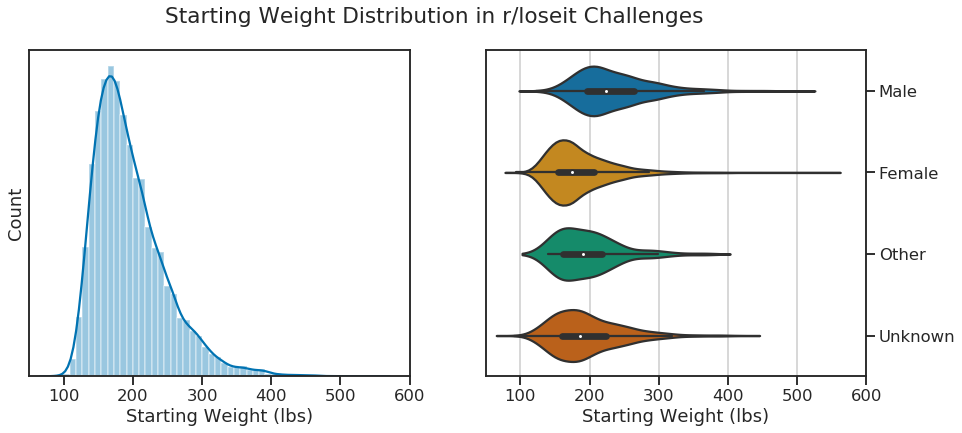

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.distplot(loss_df["Starting Weight"], ax=ax1)
ax1.set_yticks([])
ax1.set_ylabel("Count")
ax1.set_xlim([50, 600])
ax1.set_xlabel("Starting Weight (lbs)")

sns.violinplot(x="Starting Weight", y="Gender", data=loss_df, ax=ax2)
ax2.xaxis.grid(True)
ax2.set(ylabel="")
ax2.set_xlim([50, 600])
ax2.set_xlabel("Starting Weight (lbs)")
ax2.yaxis.tick_right()

f.suptitle("Starting Weight Distribution in r/loseit Challenges")

f.savefig("../figures/violin_gender_start_weight.png", dpi=400)
plt.show()

print(
    f"The average starting weight is {loss_df['Starting Weight'].mean():.1f} lbs. The highest starting weight so far has been {loss_df['Starting Weight'].max()} lbs. and the lowest has been {loss_df['Starting Weight'].min()} lbs. So really no matter how much you have to lose (or gain) these challenges are the place for you!"
)

The average starting weight is 196.3 lbs. The highest starting weight so far has been 546.8 lbs. and the lowest has been 90.3 lbs. So really no matter how much you have to lose (or gain) these challenges are the place for you!


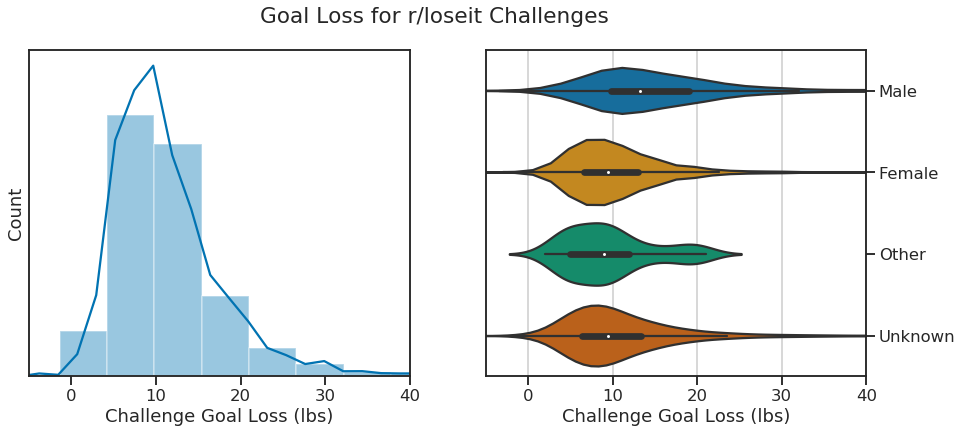

The average goal loss for the challenges is 10.0 lbs. This entry had a few outliers that are incorrect entries, so rather than using the mean for average, we use the median.


In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

rng = [-5, 40]

sns.distplot(loss_df["Challenge Goal Loss"], ax=ax1)
ax1.set_yticks([])
ax1.set_ylabel("Count")
ax1.set_xlim(rng)
ax1.set_xlabel("Challenge Goal Loss (lbs)")

sns.violinplot(x="Challenge Goal Loss", y="Gender", data=loss_df, ax=ax2)
ax2.xaxis.grid(True)
ax2.set(ylabel="")
ax2.set_xlim(rng)
ax2.set_xlabel("Challenge Goal Loss (lbs)")
ax2.yaxis.tick_right()

f.suptitle("Goal Loss for r/loseit Challenges")

f.savefig("../figures/violin_gender_goal_loss.png", dpi=400)
plt.show()

print(
    f"The average goal loss for the challenges is {loss_df['Challenge Goal Loss'].median():.1f} lbs. This entry had a few outliers that are incorrect entries, so rather than using the mean for average, we use the median."
)

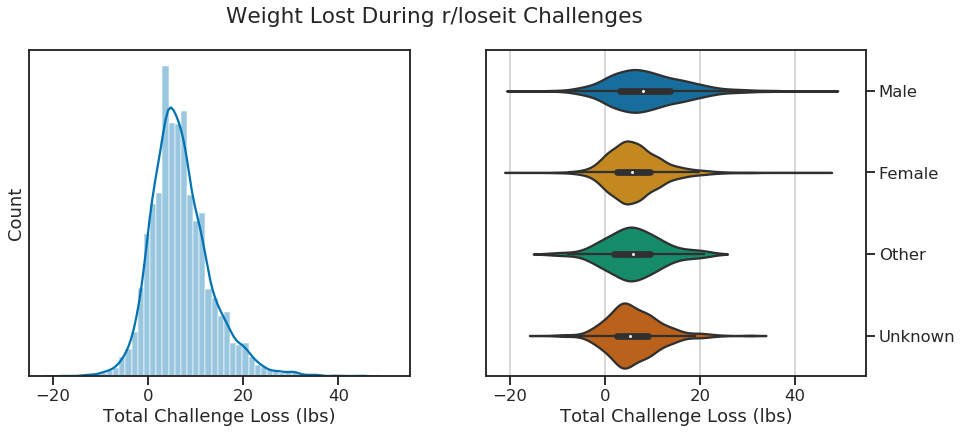

The average weight lost during the challenges is 6.0 lbs. The most weight lost during a challenge is 45.7 lbs.


In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

rng = [-25, 55]

sns.distplot(loss_df["Total Challenge Loss"], ax=ax1)
ax1.set_yticks([])
ax1.set_ylabel("Count")
ax1.set_xlim(rng)
ax1.set_xlabel("Total Challenge Loss (lbs)")

sns.violinplot(x="Total Challenge Loss", y="Gender", data=loss_df, ax=ax2)
ax2.xaxis.grid(True)
ax2.set(ylabel="")
ax2.set_xlim(rng)
ax2.set_xlabel("Total Challenge Loss (lbs)")
ax2.yaxis.tick_right()

f.suptitle("Weight Lost During r/loseit Challenges")

f.savefig("../figures/violin_gender_weight_loss.png", dpi=400)
plt.show()

print(
    f"The average weight lost during the challenges is "
    f"{loss_df['Total Challenge Loss'].median():.1f} lbs."
    f" The most weight lost during a challenge is "
    f"{loss_df['Total Challenge Loss'].max():.1f} lbs."
)

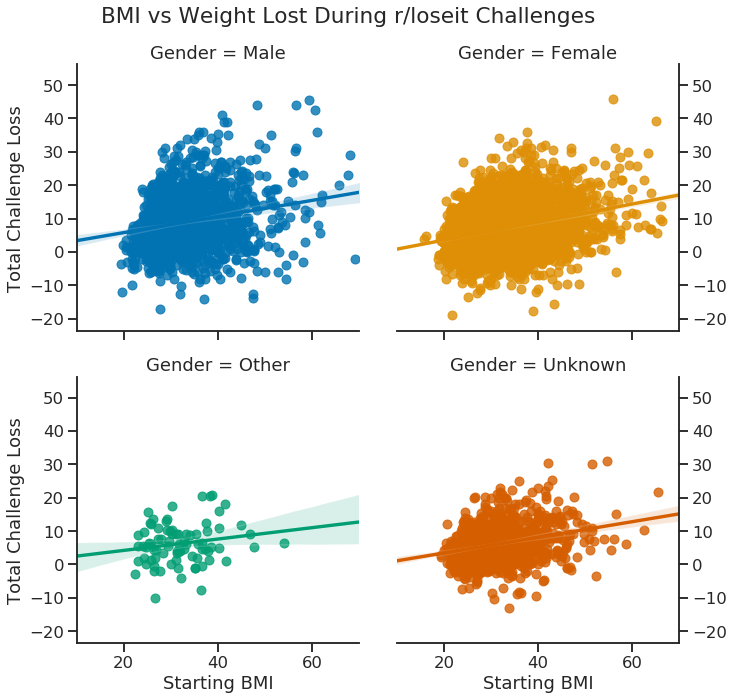

In these plots we see that there is a slight correlation between starting BMI and the amount of weight that is lost during the challenges. This relationship seems independent of gender.


In [21]:
g = sns.lmplot(
    x="Starting BMI",
    y="Total Challenge Loss",
    data=loss_df,
    hue="Gender",
    col="Gender",
    col_wrap=2,
)

for ax in g.axes:
    ax.set_xlim([10, 70])

g.axes[1].yaxis.tick_right()
g.axes[1].spines["right"].set_visible(True)
g.axes[1].spines["left"].set_visible(False)

g.axes[3].yaxis.tick_right()
g.axes[3].spines["right"].set_visible(True)
g.axes[3].spines["left"].set_visible(False)

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("BMI vs Weight Lost During r/loseit Challenges")

g.savefig("../figures/scatter_gender_weight_loss_v_bmi.png", dpi=400)
plt.show()

print(
    "In these plots we see that there is a slight correlation "
    "between starting BMI and the amount of weight that is lost"
    " during the challenges. This relationship seems independent of "
    "gender."
)

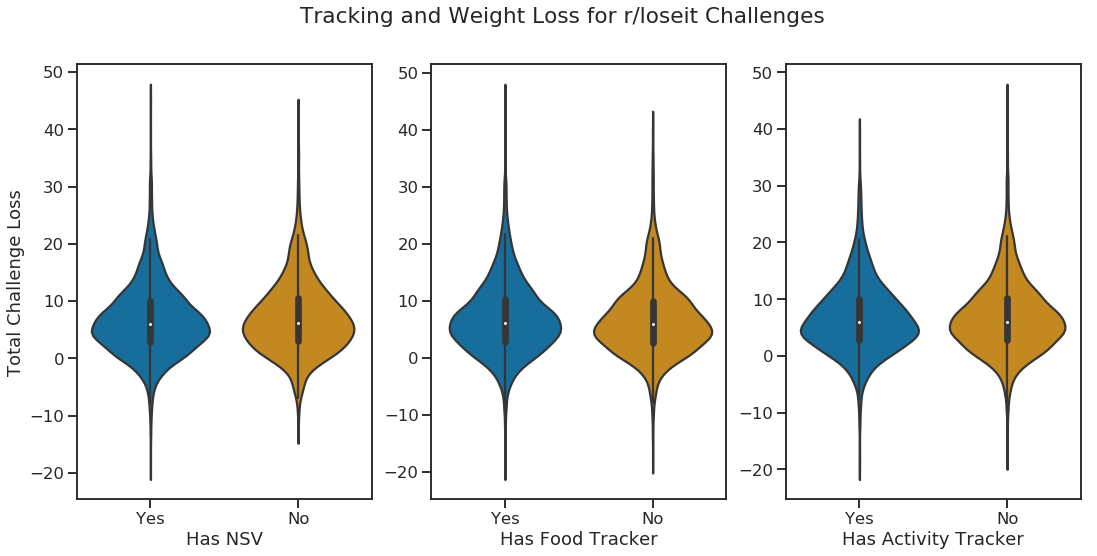

From these plots we see that giving a NSV, activity tracker, or food tracker does not have much of an affect of weight lost. One thing that I would be curious to see, is if the inter-team challenges/participation is correlated with weight loss.


In [34]:
nsv_dat = loss_df["Has NSV"].astype(str).str.replace("1", "Yes").str.replace("0", "No")
tracker_dat = (
    loss_df["Has Food Tracker"]
    .astype(str)
    .str.replace("1", "Yes")
    .str.replace("0", "No")
)
activity_dat = (
    loss_df["Has Activity Tracker"]
    .astype(str)
    .str.replace("1", "Yes")
    .str.replace("0", "No")
)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))
sns.violinplot(y=loss_df["Total Challenge Loss"], x=nsv_dat, ax=ax1)
sns.violinplot(y=loss_df["Total Challenge Loss"], x=tracker_dat, ax=ax2)
sns.violinplot(y=loss_df["Total Challenge Loss"], x=activity_dat, ax=ax3)
ax2.set_ylabel("")
ax3.set_ylabel("")

f.suptitle("Tracking and Weight Loss for r/loseit Challenges")
f.savefig("../figures/violin_weight_loss_nsv.png", dpi=400)
plt.show()

print(
    "From these plots we see that giving a NSV, activity tracker, or food tracker does not have much of an affect of weight lost. One thing that I would be curious to see, is if the inter-team challenges/participation is correlated with weight loss."
)

### NSV and Tracking

Next, I want to look at the proportion of those who give links to either fitness or food trackers and provide a NSV.

In [23]:
print(f"Has NSV: {big_df['Has NSV'].sum()/len(big_df) * 100:.2f}")
print(
    f"Gives activity tracker: {big_df['Has Activity Tracker'].sum()/len(big_df) * 100:.2f}"
)
print(f"Gives food tracker: {big_df['Has Food Tracker'].sum()/len(big_df) * 100:.2f}")

Has NSV: 78.82
Gives activity tracker: 20.78
Gives food tracker: 57.00


In [24]:
# making sets for a venn diagram
nsv = big_df["Has NSV"]  # A
at = big_df["Has Activity Tracker"]  # B
big_df["Has Food Tracker"]  # C

Abc = (
    (
        (big_df["Has Activity Tracker"] + big_df["Has Food Tracker"])[
            big_df["Has NSV"] == 1
        ]
        == 0
    )
    .astype(int)
    .sum()
)
aBc = (
    (
        (big_df["Has NSV"] + big_df["Has Food Tracker"])[
            big_df["Has Activity Tracker"] == 1
        ]
        == 0
    )
    .astype(int)
    .sum()
)
ABc = (
    (
        (big_df["Has NSV"] + big_df["Has Activity Tracker"])[
            big_df["Has Food Tracker"] == 0
        ]
        == 2
    )
    .astype(int)
    .sum()
)
abC = (
    (
        (big_df["Has NSV"] + big_df["Has Activity Tracker"])[
            big_df["Has Food Tracker"] == 1
        ]
        == 0
    )
    .astype(int)
    .sum()
)
AbC = (
    (
        (big_df["Has NSV"] + big_df["Has Food Tracker"])[
            big_df["Has Activity Tracker"] == 0
        ]
        == 2
    )
    .astype(int)
    .sum()
)
aBC = (
    (
        (big_df["Has Activity Tracker"] + big_df["Has Food Tracker"])[
            big_df["Has NSV"] == 0
        ]
        == 2
    )
    .astype(int)
    .sum()
)
ABC = (
    (
        (
            big_df["Has Activity Tracker"]
            + big_df["Has Food Tracker"]
            + big_df["Has NSV"]
        )
        == 3
    )
    .astype(int)
    .sum()
)
abc = (
    (
        (
            big_df["Has Activity Tracker"]
            + big_df["Has Food Tracker"]
            + big_df["Has NSV"]
        )
        == 0
    )
    .astype(int)
    .sum()
)

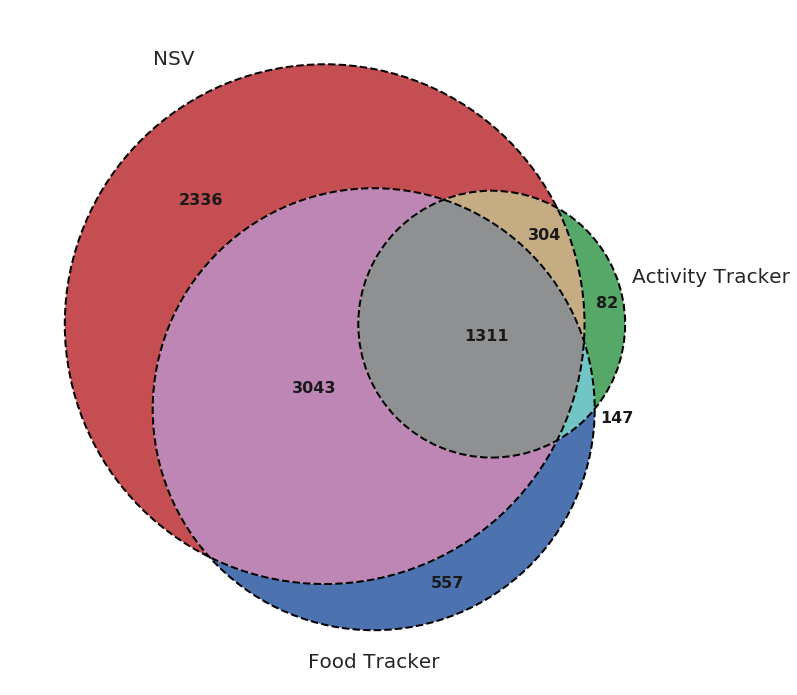

In [25]:
venn_colors = sns.color_palette()[::-1]
venn_labels = ["".join(seq) for seq in itertools.product("01", repeat=3)][1:]

f, ax = plt.subplots(figsize=(10, 10))

v = venn3(
    subsets=(Abc, aBc, ABc, abC, AbC, aBC, ABC),
    set_labels=("NSV", "Activity Tracker", "Food Tracker"),
    alpha=1,
)
venn3_circles(
    subsets=(Abc, aBc, ABc, abC, AbC, aBC, ABC), linestyle="dashed", linewidth=2
)

# setting the colors to match the color palette used in other plots
for i, label in enumerate(venn_labels):
    v.get_label_by_id(label).set_color(venn_colors[i])

# shifting labels to get centered text
v.get_label_by_id("011").set_x(0.52)
v.get_label_by_id("011").set_y(-0.13)
v.get_label_by_id("110").set_x(0.37)
v.get_label_by_id("111").set_x(0.25)
v.get_label_by_id("111").set_y(0.04)
v.get_label_by_id("010").set_x(0.5)

v.set_labels[1].set_x(0.55)
v.set_labels[1].set_y(0.15)

# font size changes
for text in v.set_labels:
    text.set_fontsize(20)

for text in v.subset_labels:
    text.set_fontsize(16)
    text.set_color("k")
    text.set_fontweight("bold")

f.tight_layout()
f.savefig("../figures/nsv_activity_food_tracker_venn_diagram.png", dpi=400)

In [26]:
print(
    f"number of people who don't give any info: {abc}, {(abc/len(big_df) * 100):.2f}%"
)

number of people who don't give any info: 1093, 12.32%


# Challenge Data

In the last section we examined statistics about the participants of the challenges. In this section we will examine the challenge and team data.

In [27]:
def user_data(big_df):
    return big_df[big_df.Username == user].sort_values(by="Timestamp")

In [28]:
print(
    f"So far there have been {len(big_df.Challenge.unique())} loseit challenges with {len(big_df.Team.unique())} teams for those challenges."
)

So far there have been 10 loseit challenges with 76 teams for those challenges.


In [29]:
print(
    f'Challenge names \t\t [number of people]\n\n{start}{big_df.sort_values(by="Timestamp").Challenge.value_counts().to_string()}{end}'
)

Challenge names 		 [number of people]

Spring Into Summer Challenge            1063
Mythical Creatures Spring Challenge     1022
Super Mario Brothers Super Challenge    1013
Super Hero Summer Challenge              966
Rebirth Challenge                        877
New New Year New Goals Challenge         860
Lord Of The Rings Summer Challenge       858
The Summer Challenge                     791
Scifi Movies Challenge                   744
Autumn Animal Challenge                  679


In [30]:
challenge_df = loss_df[
    [
        "Timestamp",
        "Username",
        "Team",
        "Challenge",
        "Age",
        "Highest Weight",
        "Starting Weight",
        "Challenge Goal Loss",
        "Total Challenge Loss",
    ]
]
group_df = challenge_df.groupby(by=["Challenge", "Team"])
with pd.option_context("display.max_rows", 100, "display.max_columns", 25):
    display(group_df.mean())

Age  \
Challenge                            Team                        
Autumn Animal Challenge              Cougar          28.500000   
                                     Cougar          27.666667   
                                     Dodo            29.875000   
                                     Lynx            29.575758   
                                     Panda           28.898551   
                                     Rhinoceros      28.238095   
                                     Seahorse        28.591304   
                                     Shark           29.934426   
                                     Tiger           28.009009   
Lord Of The Rings Summer Challenge   2nd Breakfast   29.155340   
                                     Bravest Hobbit  29.237705   
                                     Ents            30.320611   
                                     Frodo And Sam   28.917526   
                                     Gollum          29.059524   
                                     Radagast        29.451613   
                                     Rivendell       28.220339   
                                     Shadowfax       30.205674   
Mythical Creatures Spring Challenge  Cerberus        29.470149   
                                     Chupacabra      28.281250   
                                     Dragon          28.990476   
                                     Pegasus         28.008264   
                                     Phoenix         28.007937   
                                     Unicorn         29.156028   
                                     Werewolf        29.120968   
                                     Yeti            29.372263   
New New Year New Goals Challenge     Hamster         29.300000   
                                     Kākāriki        28.275000   
                                     Leopard Gecko   28.967391   
                                     Owl             28.622222   
                                     Pug             28.770492   
                                     Ragdoll Kitten  28.455357   
                                     Teacup Pig      28.900000   
                                     Turtle          29.931034   
Rebirth Challenge                    Bat             28.578947   
                                     Monarch         28.889952   
                                     Phoenix         28.060837   
                                     Snake           28.395349   
Scifi Movies Challenge               Alien           29.652632   
                                     Avatar          28.895349   
                                     Blade Runner    26.989247   
                                     Fifth Element   28.168142   
                                     Martian         29.227723   
                                     Matrix          27.954128   
                                     Predator        27.473684   
                                     Terminator      30.704225   
Spring Into Summer Challenge         Crocus          28.712871   
                                     Daffodil        27.548673   
                                     Duckling        27.831461   
                                     Fawn            29.568627   
                                     Hayfever        28.873684   
                                     Ladybug         28.534247   
                                     Pollen          28.867925   
                                     Robin           27.823529   
                                     Seedling        26.596154   
                                     Thunderstorm    28.586538   
Super Hero Summer Challenge          Batman          27.698113   
                                     Deadpool        29.344262   
                                     Hulk            28.076923   
                                     Ironman         28.044776   
                                 

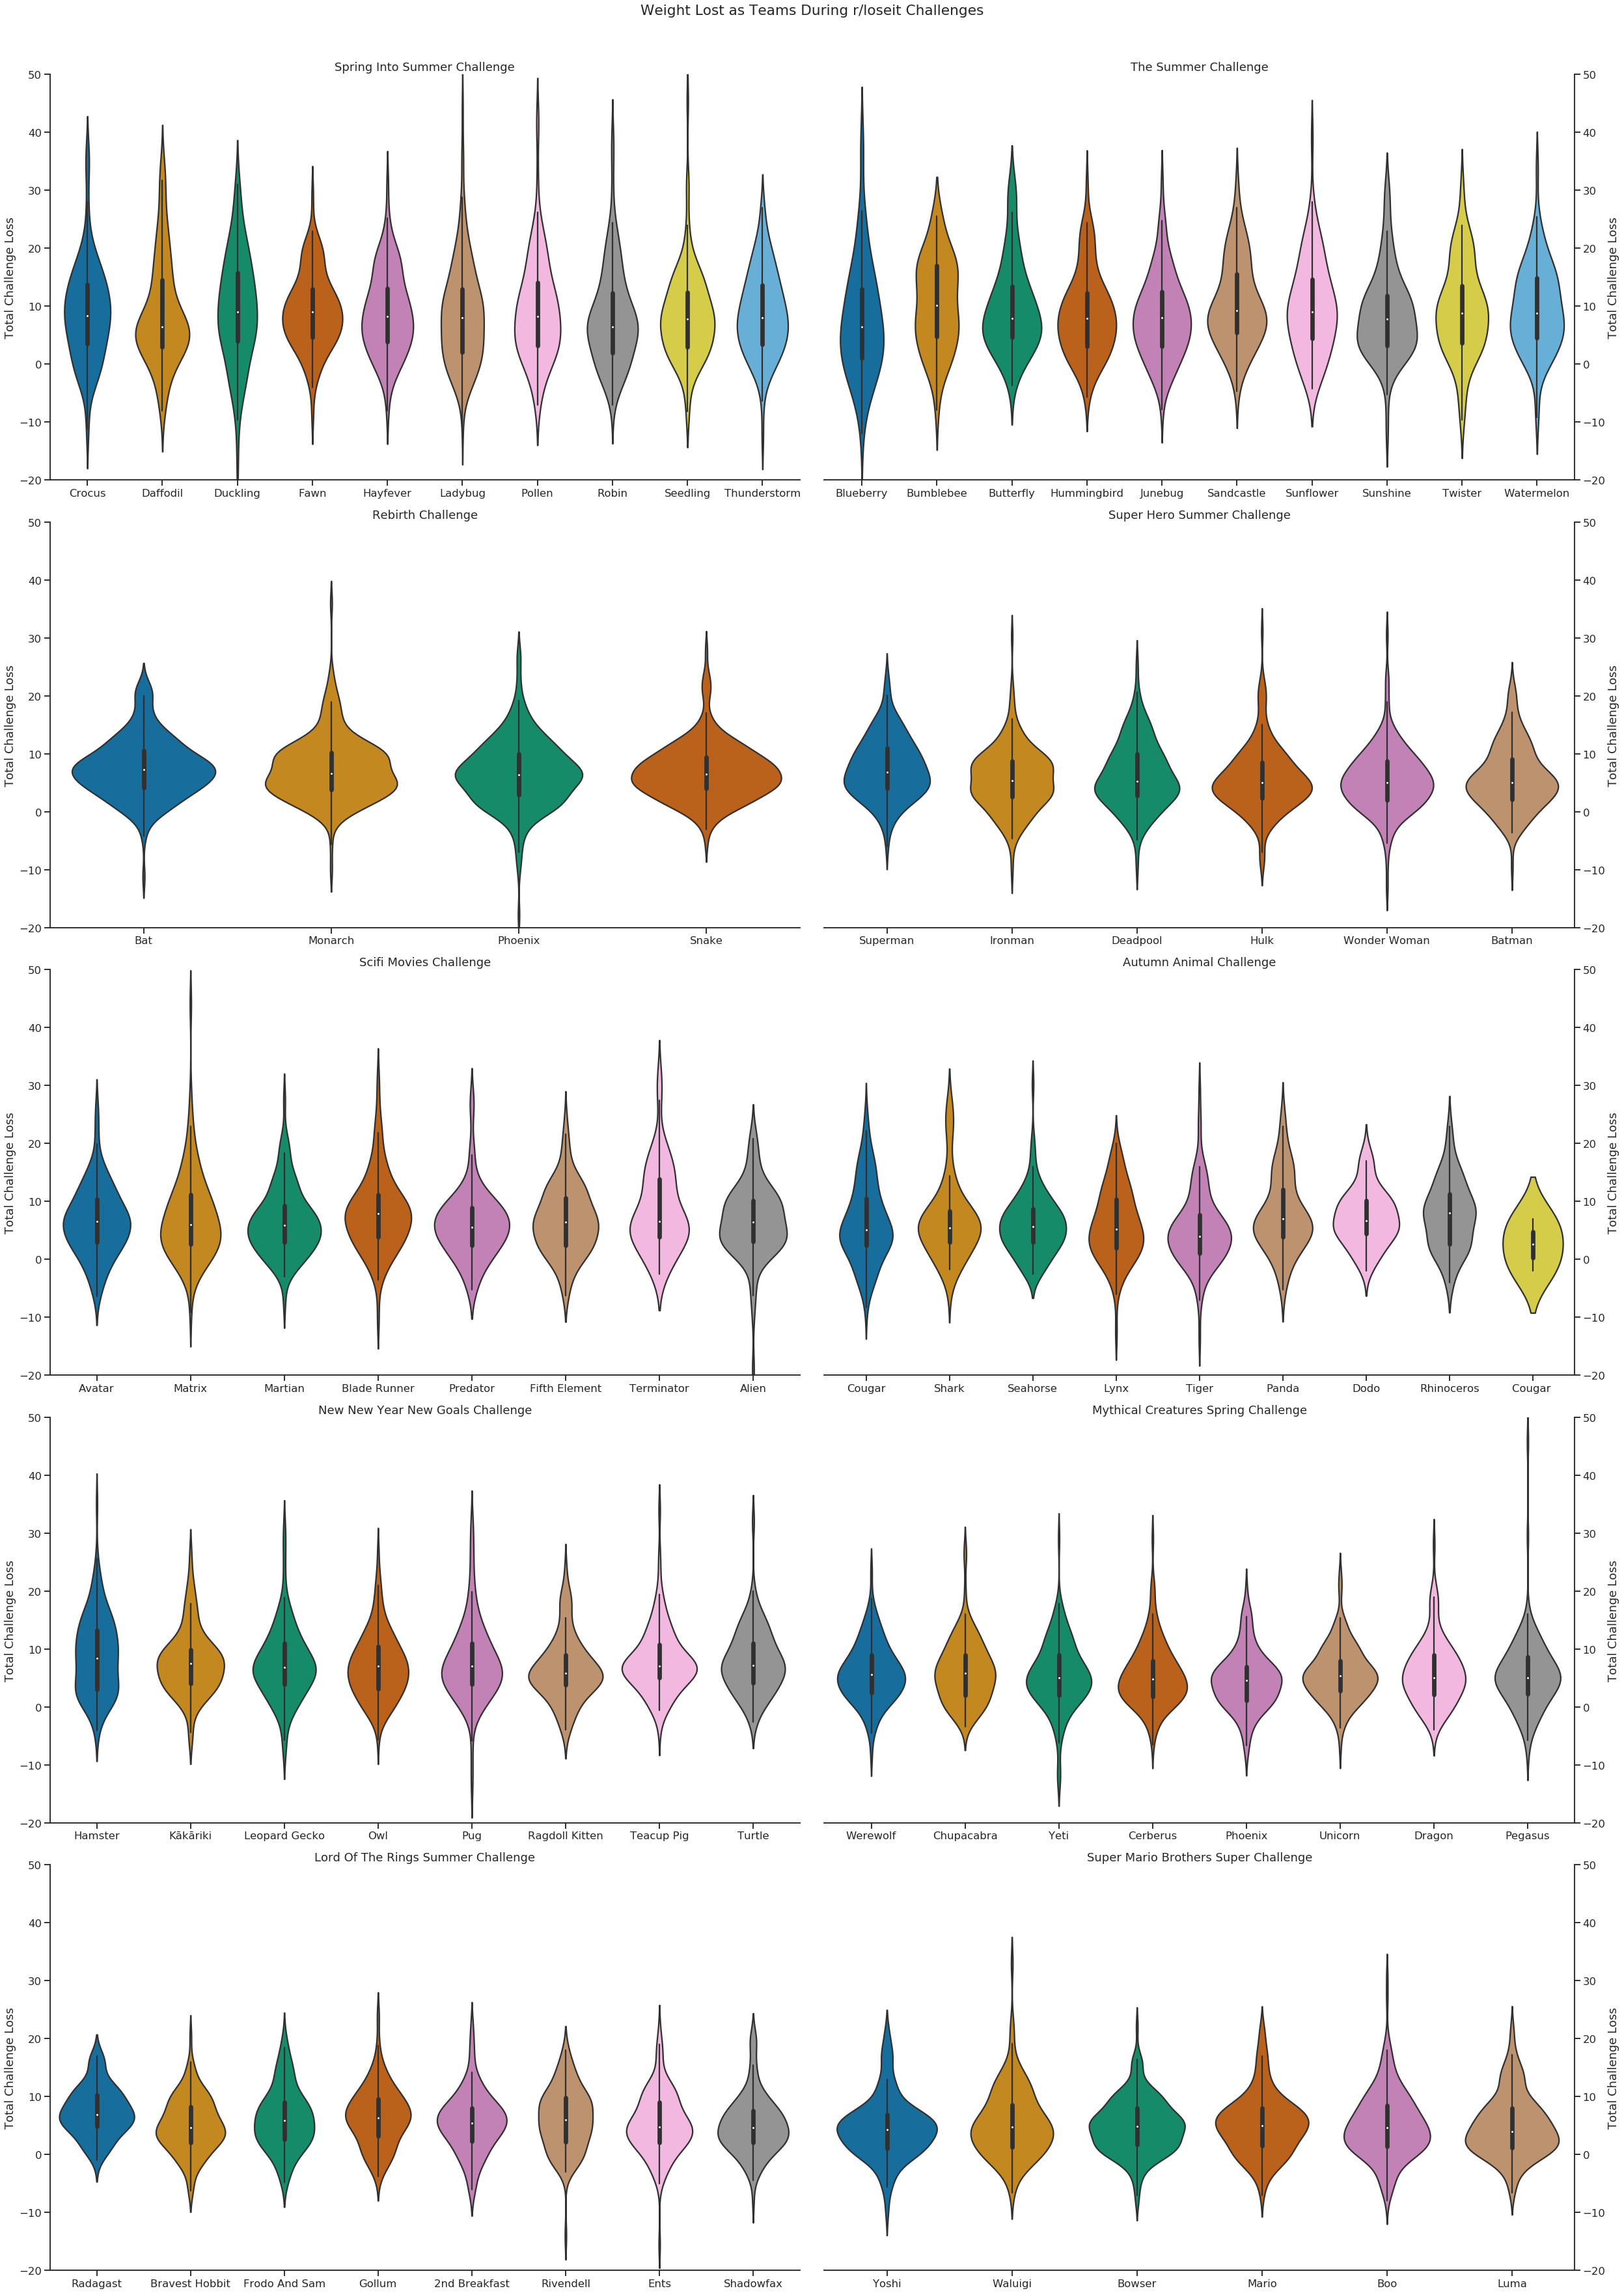

In [31]:
g = sns.FacetGrid(
    loss_df,
    col="Challenge",
    col_wrap=2,
    height=10,
    aspect=1.75,
    sharex=False,
    ylim=(-20, 50),
)

for idx, ax, challenge in zip(
    range(10),
    g.axes,
    big_df[~big_df.duplicated(subset=["Challenge"])].sort_values("Timestamp").Challenge,
):
    chal_df = loss_df[loss_df.Challenge == challenge]["Total Challenge Loss"]
    teams = loss_df[loss_df.Challenge == challenge].Team
    sns.violinplot(y=chal_df, x=teams, ax=ax)

    ax.set_title(challenge)
    ax.set_xlabel("")

    if idx % 2 == 1:
        ax.yaxis.tick_right()
        ax.spines["right"].set_visible(True)
        ax.spines["left"].set_visible(False)
        ax.yaxis.set_label_position("right")

g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("Weight Lost as Teams During r/loseit Challenges")
g.fig.savefig("../figures/low_res_violin_weight_loss_v_team.png", dpi=300)
g.fig.savefig("../figures/high_res_violin_weight_loss_v_team.png", dpi=500)

plt.show()

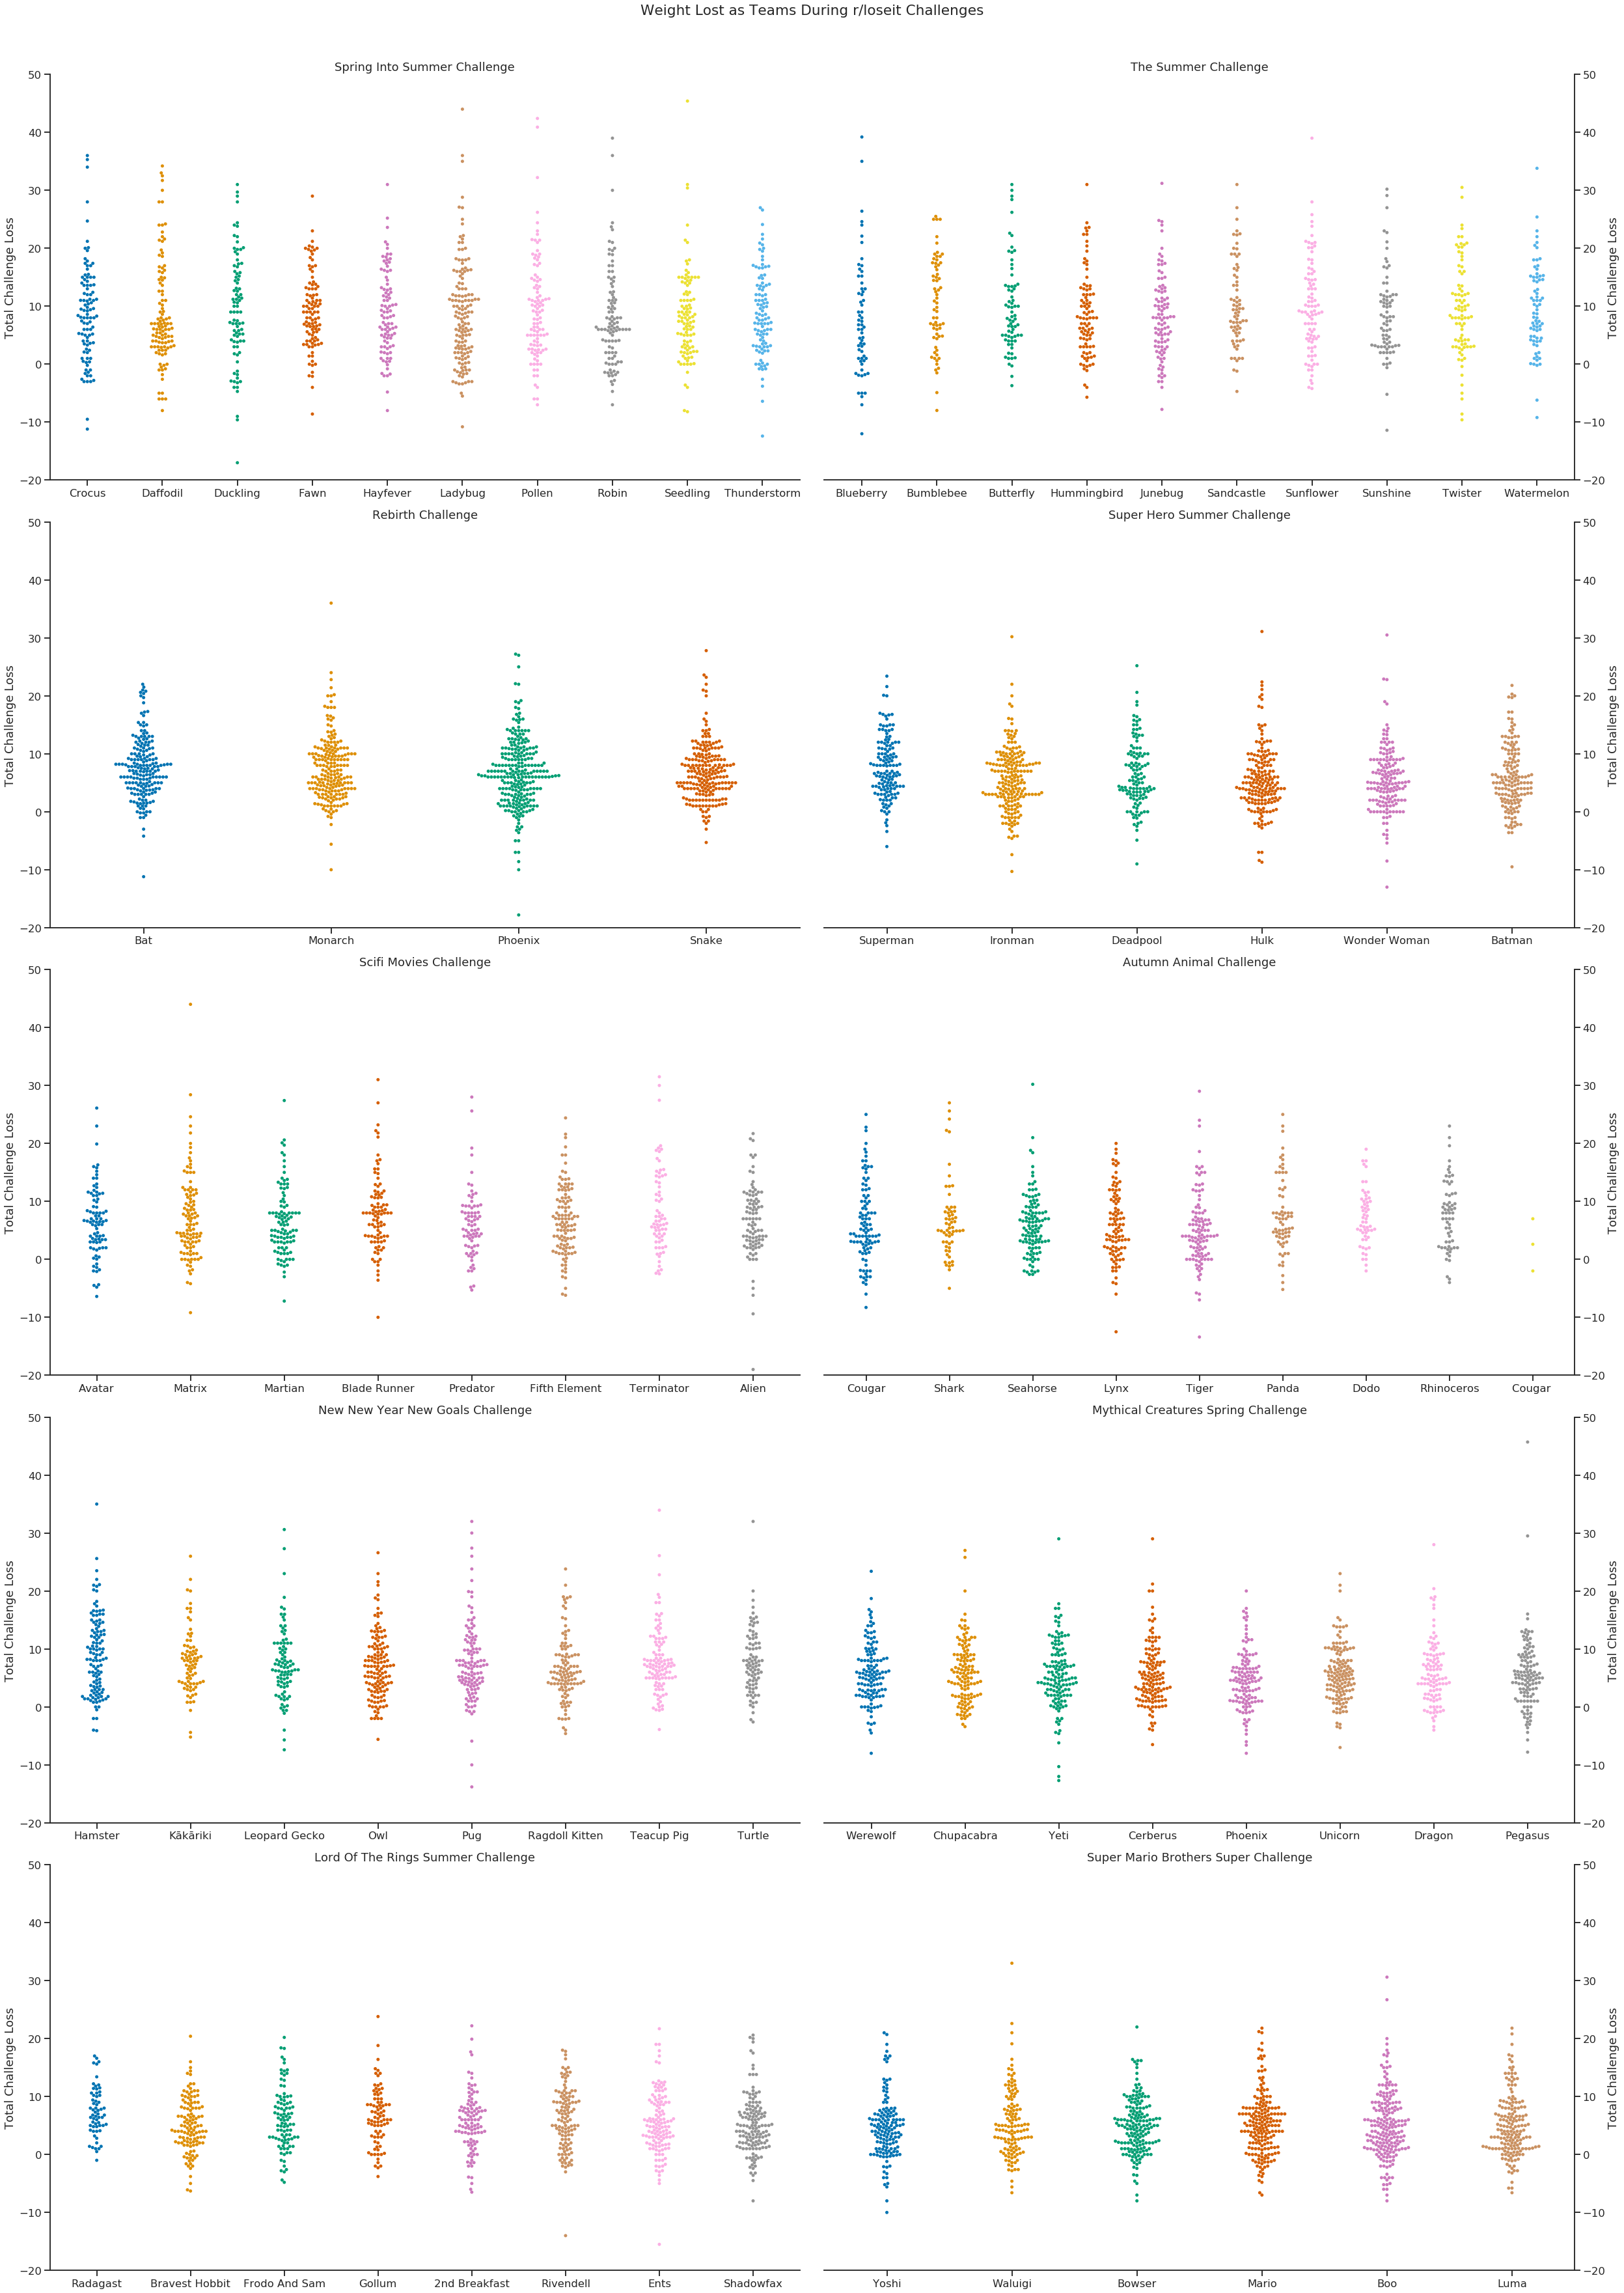

In [32]:
g = sns.FacetGrid(
    loss_df,
    col="Challenge",
    col_wrap=2,
    height=10,
    aspect=1.75,
    sharex=False,
    ylim=(-20, 50),
)

for idx, ax, challenge in zip(
    range(10),
    g.axes,
    big_df[~big_df.duplicated(subset=["Challenge"])].sort_values("Timestamp").Challenge,
):
    chal_df = loss_df[loss_df.Challenge == challenge]["Total Challenge Loss"]
    teams = loss_df[loss_df.Challenge == challenge].Team
    sns.swarmplot(y=chal_df, x=teams, ax=ax)

    ax.set_title(challenge)
    ax.set_xlabel("")

    if idx % 2 == 1:
        ax.yaxis.tick_right()
        ax.spines["right"].set_visible(True)
        ax.spines["left"].set_visible(False)
        ax.yaxis.set_label_position("right")

g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("Weight Lost as Teams During r/loseit Challenges")
g.fig.savefig("../figures/low_res_swarm_weight_loss_v_team.png", dpi=300)
g.fig.savefig("../figures/high_res_swarm_weight_loss_v_team.png", dpi=500)

plt.show()

### NSV Analysis

For the last part I want to look at the NSV that people give and try to find what are the most common goals that people have for losing weight.

In [33]:
combined_nsv = ""
for idx in range(len(big_df)):
    combined_nsv += f'{big_df["NSV Text"].values[idx]}. '

stop = stopwords.words("english")
big_df["nsv"] = big_df["NSV Text"].apply(
    lambda x: " ".join([word for word in x.split() if word not in (stop)])
)
print(
    "After removing stop words, these are the 10 most common reasons for wanting to lose weight."
)
display(Counter(big_df["nsv"].str.lower().str.strip()).most_common(11)[1:])

After removing stop words, these are the 10 most common reasons for wanting to lose weight.


[('run 5k', 76),
 ('fit old clothes', 59),
 ('run 10k', 31),
 ('fit old jeans', 21),
 ('finish c25k', 20),
 ('go pant size', 13),
 ('fit clothes better', 11),
 ('no', 10),
 ('run 5k without stopping', 10),
 ('run mile', 10)]

In [35]:
# doc = nlp(combined_nsv)
# # all tokens that arent stop words or punctuations
# words = [token.text for token in doc.doc if token.is_stop !=
#          True and token.is_punct != True]
# # noun tokens that arent stop words or punctuations
# nouns = [token.text for token in doc.doc if token.is_stop !=
#          True and token.is_punct != True and token.pos_ == "NOUN"]

# # five most common tokens
# word_freq = Counter(words)
# common_words = word_freq.most_common(5)

# # five most common noun tokens
# noun_freq = Counter(nouns)
# common_nouns = noun_freq.most_common(5)

# display(common_words)
# display(common_nouns)

In this next section, we want to create a word cloud so that we can visualize some of the most common words that people use to describe their reasons for wanting to lose weight during r/loseit challenges.


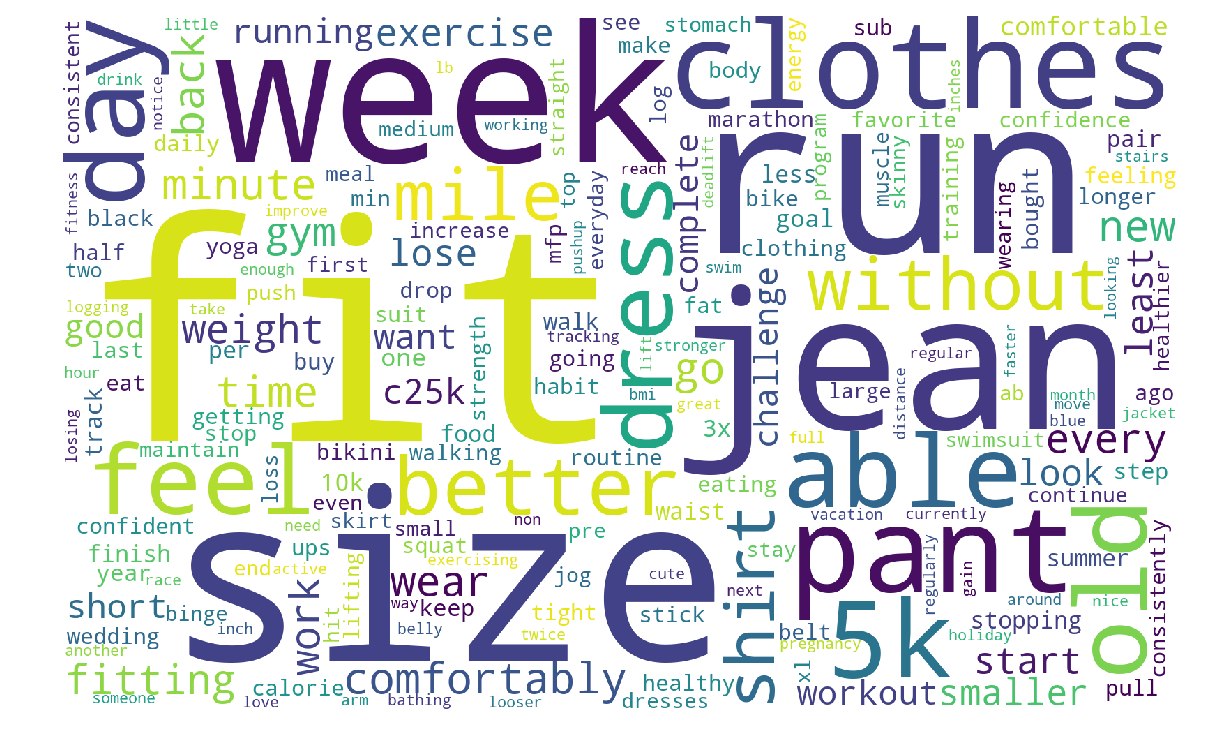

In [36]:
print(
    "In this next section, we want to create a word cloud so "
    "that we can visualize some of the most common words that "
    "people use to describe their reasons for wanting to "
    "lose weight during r/loseit challenges."
)

# Create and generate a word cloud image:
text = " ".join(review for review in big_df["nsv"].str.lower().str.strip())
text = text.lower()

wordcloud = WordCloud(
    background_color="white",
    width=1600,
    height=1000,
    collocations=False,
    stopwords=STOPWORDS,
).generate(text)

# Display the generated image:
plt.figure(figsize=(20, 15), facecolor="w")
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig(
    f"../figures/spacy_noStopwords_nsv_wordcloud.png", facecolor="w", bbox_inches="tight"
)

In [37]:
print(
    "And finally, in this last section we can copy our nsv text "
    "to https://www.jasondavies.com/wordcloud/ to create a word cloud"
    " that uses D3-cloud"
)
text;

print("\n\n\nAnd now we are done!!!!")

And finally, in this last section we can copy our nsv text to https://www.jasondavies.com/wordcloud/ to create a word cloud that uses D3-cloud



And now we are done!!!!
